In [54]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [55]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [56]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [57]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

Shape of the TIFF stack: (200, 224, 224)
[[ 36.060997   21.221      14.32      ... 124.        117.
  117.       ]
 [ 36.060997   21.221      14.32      ... 124.        117.
  117.       ]
 [ 24.060997    8.221001    1.3199997 ... 123.        122.
  122.       ]
 ...
 [ 12.060997   10.221001    3.3199997 ... 115.        131.
  131.       ]
 [ 12.060997   10.221001    3.3199997 ... 115.        131.
  131.       ]
 [ 16.060997    7.2210007   0.3199997 ... 140.        135.
  135.       ]]


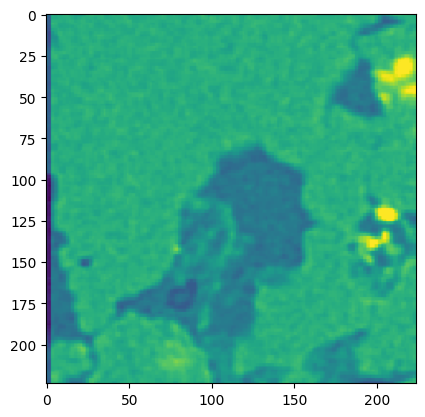

Shape of the TIFF stack: (200, 224, 224)
[[ 36.060997   21.221      14.32      ... 124.        117.
  117.       ]
 [ 36.060997   21.221      14.32      ... 124.        117.
  117.       ]
 [ 24.060997    8.221001    1.3199997 ... 123.        122.
  122.       ]
 ...
 [ 12.060997   10.221001    3.3199997 ... 115.        131.
  131.       ]
 [ 12.060997   10.221001    3.3199997 ... 115.        131.
  131.       ]
 [ 16.060997    7.2210007   0.3199997 ... 140.        135.
  135.       ]]


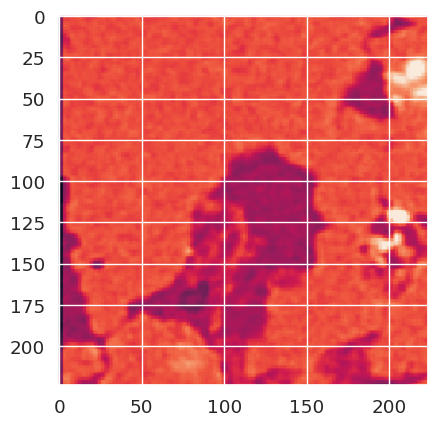

In [60]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'

train_images = io.imread(stack_path)

resized_train_images = []
for image in train_images[:200]:
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
    image = keras.applications.vgg19.preprocess_input(resized_image)
    resized_train_images.append(image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)
plt.imshow(train_images[0])

print(train_images[0])

Shape of the TIFF stack: (200, 224, 224)
[1 2 3 4]


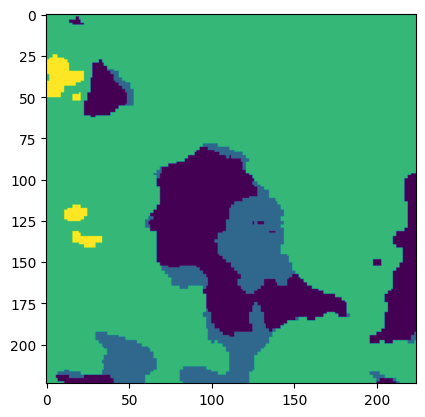

Shape of the TIFF stack: (200, 224, 224)
[1 2 3 4]


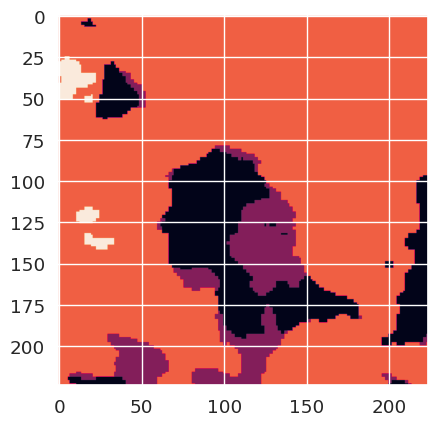

In [61]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

resized_train_masks = []
for image in train_masks[:200]:
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
    resized_train_masks.append(resized_image)

train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

plt.imshow(train_masks[0])
print(np.unique(train_masks[0]))

In [62]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

200 224 224


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

200 224 224


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [63]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(200, 224, 224, 1)
(200, 224, 224, 1)


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(180, 224, 224)
(20, 224, 224)
(180, 224, 224, 1)
(20, 224, 224, 1)
(180, 224, 224)
(20, 224, 224)
(180, 224, 224, 1)
(20, 224, 224, 1)


In [65]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]
Class values in the dataset are ...  [0 1 2 3]


In [66]:
# Categorical encoding
from keras.utils import to_categorical
n_classes=4
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [67]:
print(y_train_cat.shape)

(180, 224, 224, 4)
(180, 224, 224, 4)


In [68]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [2.00082145 2.77031802 0.33110931 8.39734771]
Class Weights: [2.00082145 2.77031802 0.33110931 8.39734771]


# Defining the model (FCN 32)




https://www.kaggle.com/code/santhalnr/cityscapes-image-segmentation-pspnet

In [69]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [70]:
import tensorflow as tf
from tensorflow import keras

NUM_CLASSES = 4

# Define the input layer
input_layer = keras.Input(shape=(224, 224, 1))

# Create the VGG model without pre-trained weights
vgg_model = keras.applications.VGG19(
    include_top=False, weights=None, input_tensor=input_layer, classes=4)

# Make VGG layers trainable
for layer in vgg_model.layers:
    layer.trainable = True

# Get the output from the last pooling layer of VGG (block5_pool)
x = vgg_model.get_layer("block5_pool").output

# Additional convolutional layers
x = keras.layers.Conv2D(4096, (7, 7), activation="relu", padding="same")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv2D(4096, (1, 1), activation="relu", padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

# Final convolution layer to produce class scores
x = keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation="relu", padding="same")(x)

# Upsampling to the original image size
x = keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(x)

model = keras.Model(inputs=input_layer, outputs=x)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [71]:
fcn32s_optimizer =  keras.optimizers.Adam(learning_rate=0.0001)
fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        'accuracy',
    ],
)

In [19]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 162s 10s/step - loss: 1.8618 - mean_io_u: 0.1649 - accuracy: 0.4806 - val_loss: 1.8016 - val_mean_io_u: 0.1895 - val_accuracy: 0.6680
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 1.4766 - mean_io_u: 0.1876 - accuracy: 0.6520 - val_loss: 1.3024 - val_mean_io_u: 0.1951 - val_accuracy: 0.7804
Epoch 3/10
6/6 [==============================] - 3s 444ms/step - loss: 1.1575 - mean_io_u: 0.1881 - accuracy: 0.7522 - val_loss: 1.1901 - val_mean_io_u: 0.1951 - val_accuracy: 0.7804
Epoch 4/10
6/6 [==============================] - 3s 453ms/step - loss: 1.1189 - mean_io_u: 0.1881 - accuracy: 0.7522 - val_loss: 1.1183 - val_mean_io_u: 0.1951 - val_accuracy: 0.7804
Epoch 5/10
6/6 [==============================] - 3s 453ms/step - loss: 1.0664 - mean_io_u: 0.1881 - accuracy: 0.7522 - val_loss: 1.0824 - val_mean_io_u: 0.1951 - val_accuracy: 0.7804
Epoch 6/10
6/6 [==============================] - 3s 435ms/step - loss: 1.0468 - me

In [20]:
metrics = model.evaluate(X_test, y_test)
print(metrics)
print("Accuracy is = ", (metrics[2] * 100.0), "%")

1/1 [==============================] - 0s 128ms/step - loss: 1.0440 - mean_io_u: 0.1951 - accuracy: 0.7804
[1.044002890586853, 0.19510722160339355, 0.7804288864135742]
Accuracy is =  78.04288864135742 %


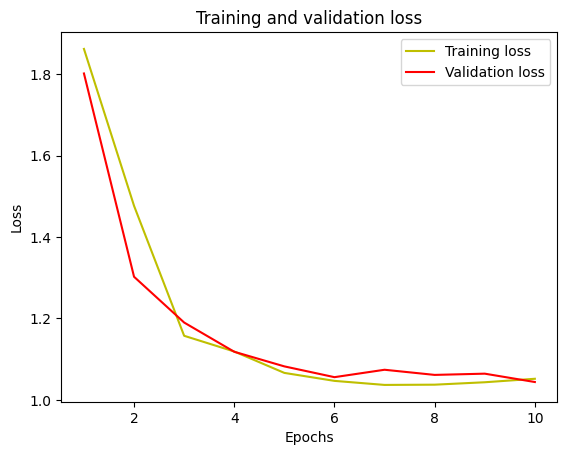

{'loss': [1.8618336915969849, 1.4765655994415283, 1.1575225591659546, 1.1189309358596802, 1.066413164138794, 1.0468273162841797, 1.036886215209961, 1.0374839305877686, 1.0434293746948242, 1.0519739389419556], 'mean_io_u': [0.1648504137992859, 0.1875765174627304, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323, 0.18805409967899323], 'accuracy': [0.4806257486343384, 0.6519564390182495, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729, 0.7522163987159729], 'val_loss': [1.8015689849853516, 1.3024369478225708, 1.1900635957717896, 1.118276834487915, 1.0824027061462402, 1.0559223890304565, 1.0741270780563354, 1.0614895820617676, 1.0645220279693604, 1.044002890586853], 'val_mean_io_u': [0.18946832418441772, 0.19510722160339355, 0.19510722160339355, 0.19510722160339355, 0.19510722160339355, 0.19510722160339355

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

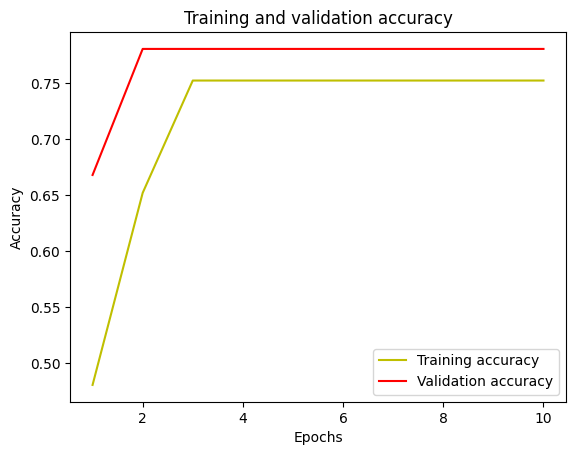

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [24]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [25]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [26]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (224, 224)
Mask Shape:  (224, 224, 4)


In [27]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (540, 224, 224)
Aug Mask Shape:  (540, 224, 224, 4)


In [28]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)

y_train_aug = np.argmax(y_train_aug, axis=-1)
y_train_aug = y_train_aug[..., np.newaxis]

print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

print(y_test.shape, X_test.shape)

Full Aug Image Shape:  (720, 224, 224)
Full Aug Mask Shape:  (720, 224, 224, 1)
(20, 224, 224, 1) (20, 224, 224)


In [29]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
model = keras.Model(inputs=input_layer, outputs=x)

fcn32s_optimizer =  keras.optimizers.Adam(learning_rate=0.001)
fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        'accuracy',
    ],
)

history_aug = model.fit(X_train_aug, y_train_aug,
                    verbose=1,
                    epochs=3,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/3
23/23 [==============================] - 39s 2s/step - loss: nan - accuracy: 0.3480 - val_loss: nan - val_accuracy: 0.1158
Epoch 2/3
23/23 [==============================] - 9s 397ms/step - loss: nan - accuracy: 0.1231 - val_loss: nan - val_accuracy: 0.1158
Epoch 3/3
23/23 [==============================] - 9s 392ms/step - loss: nan - accuracy: 0.1231 - val_loss: nan - val_accuracy: 0.1158


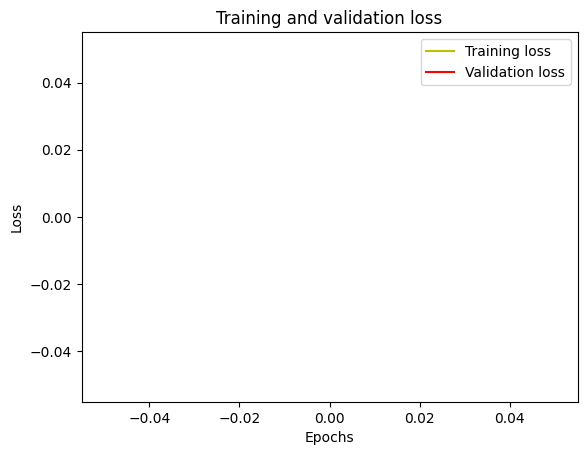

In [30]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

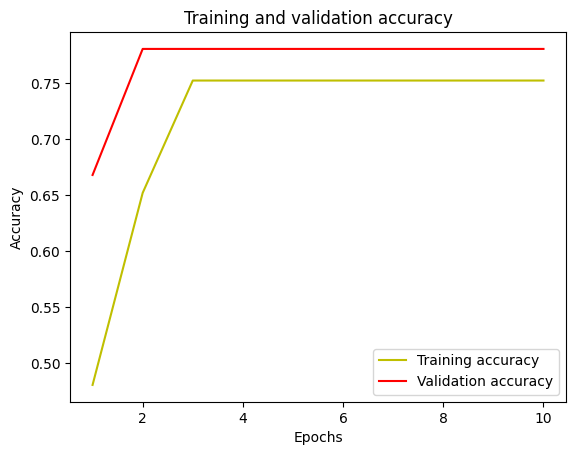

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

1/1 [==============================] - 0s 244ms/step


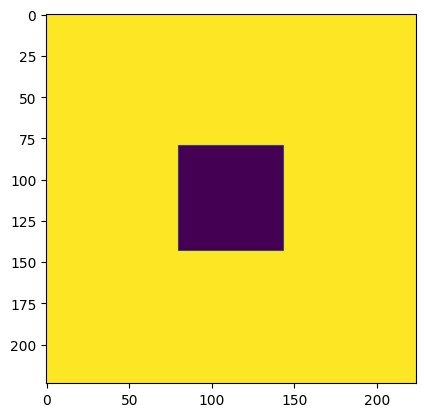

In [32]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

plt.imshow(y_pred_argmax[1])

1/1 [==============================] - 1s 703ms/step


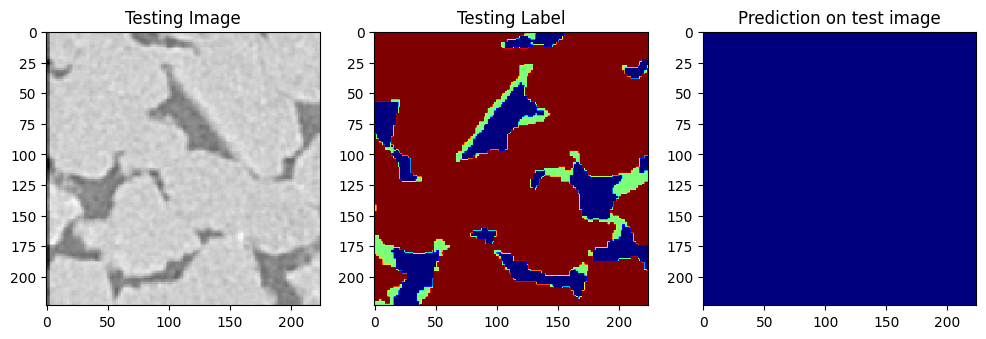

In [33]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [34]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (20, 224, 224, 4)
pred:  (20, 224, 224, 4)


In [35]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

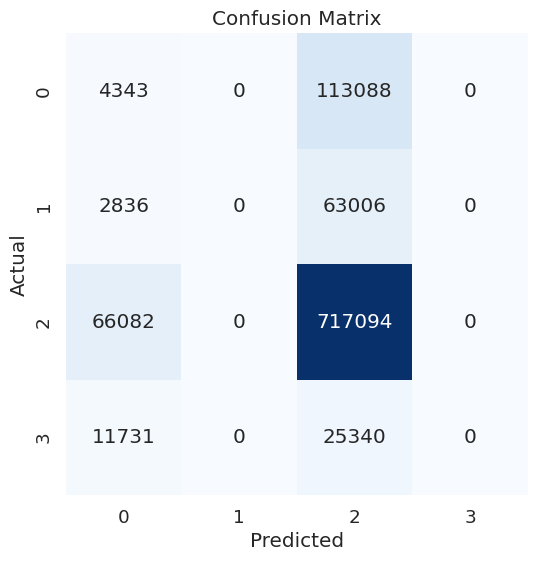

In [36]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 71.89%


In [38]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 5%
Class 1 precision: 0%
Class 2 precision: 78%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 4%
Class 1 precision: 0%
Class 2 precision: 92%
Class 3 precision: 0%


In [40]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 4%
Class 1 precision: 0%
Class 2 precision: 92%
Class 3 precision: 0%


In [41]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.18755703


In [42]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[  4343.      0. 113088.      0.]
 [  2836.      0.  63006.      0.]
 [ 66082.      0. 717094.      0.]
 [ 11731.      0.  25340.      0.]]
IoU for class1 is:  0.021925485
IoU for class2 is:  0.0
IoU for class3 is:  0.7283026
IoU for class4 is:  0.0


Training Set

In [43]:
# prediction on training set
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

6/6 [==============================] - 1s 123ms/step


1/1 [==============================] - 0s 35ms/step


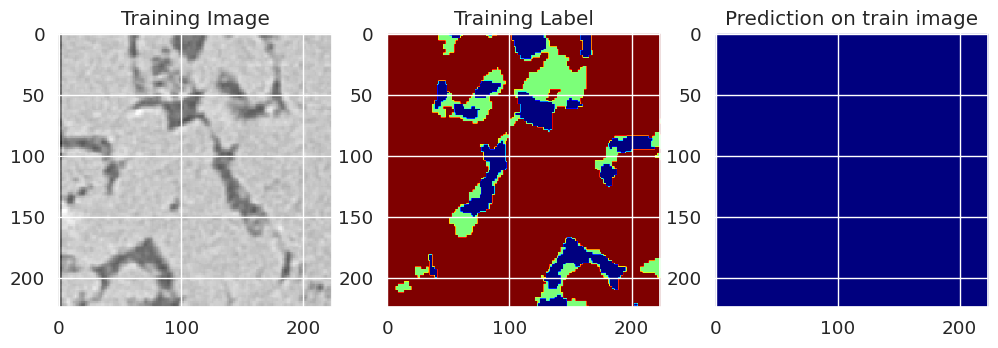

In [44]:
import random
train_img_number = random.randint(0, len(X_train))
train_img = X_train[train_img_number]
ground_truth=y_train[train_img_number]
train_img_norm=train_img[:,:][:,:,None]
train_img_input=np.expand_dims(train_img_norm, 0)
prediction = (model.predict(train_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(train_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [45]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (180, 224, 224, 4)
pred:  (180, 224, 224, 4)


In [46]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

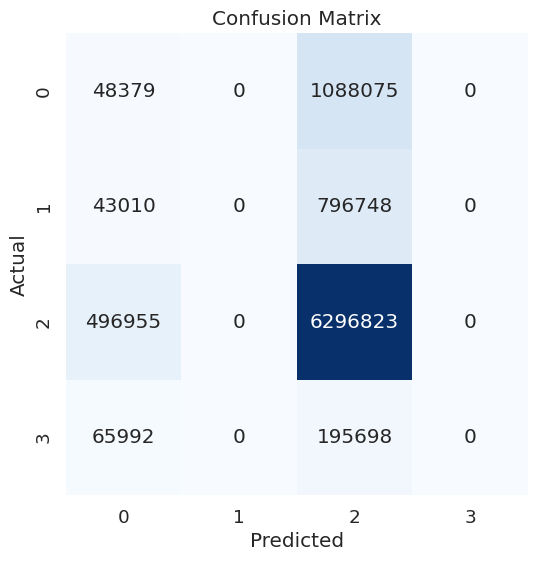

In [47]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 70.25%


In [49]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 7%
Class 1 precision: 0%
Class 2 precision: 75%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 4%
Class 1 precision: 0%
Class 2 precision: 93%
Class 3 precision: 0%


In [51]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 4%
Class 1 precision: 0%
Class 2 precision: 93%
Class 3 precision: 0%


In [52]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.1843307


In [53]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[  48379.       0. 1088075.       0.]
 [  43010.       0.  796748.       0.]
 [ 496955.       0. 6296823.       0.]
 [  65992.       0.  195698.       0.]]
IoU for class1 is:  0.02776555
IoU for class2 is:  0.0
IoU for class3 is:  0.70955724
IoU for class4 is:  0.0
